In [130]:
import pandas as pd
import sklearn 
import scipy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_boston, make_blobs, load_iris, load_digits 
from sklearn.cross_validation import train_test_split, cross_val_score, KFold, StratifiedKFold, LeaveOneOut, ShuffleSplit, LabelKFold, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics.scorer import SCORERS
from sklearn.ensemble import RandomForestClassifier 
import seaborn as sns

In [131]:
X,y = make_blobs(random_state=0)
X_train,X_test,y_train, y_test = train_test_split(X,y, random_state=0)
logreg = LogisticRegression().fit(X_train,y_train)
logreg.score(X_test,y_test)

0.88

# Cross-validation 

In [132]:
# lets use cross-validation instead of a simple split
iris = load_iris()
logreg = LogisticRegression()
kfold = 15
scores = cross_val_score(logreg, iris.data, iris.target, cv=kfold) # uses 3 folds by default 
print("cross-validation scores:", scores)

cross-validation scores: [ 1.          1.          1.          1.          0.91666667  0.88888889
  1.          1.          0.88888889  0.77777778  0.88888889  1.          1.
  1.          1.        ]


In [133]:
print(scores.mean(),scores.std())

0.957407407407 0.066408966952


## Stratified K-Fold cross-validation and other strategies

In [134]:
# relatively high variance in accuracy
# provides information about how sensitive model is to selection of training dataset
# the purpose of cross-validation is how well a given algorithm will generalize when trained on a specific dataset
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


## More control over cross-validation 

In [135]:
kfold = KFold(len(iris.data),n_folds= 3) 
# what is the difference between using KFold and just setting it into crass_val_score= (...cv= ...) ?

In [136]:
cross_val_score(logreg,iris.data,iris.target, cv= kfold) 
#without shuffling 

array([ 0.,  0.,  0.])

In [137]:
kfold = KFold(len(iris.data),shuffle = True, random_state=0, n_folds= 3)
cross_val_score(logreg,iris.data,iris.target, cv= kfold)
#with shuffling 

array([ 0.9 ,  0.96,  0.96])

In [138]:
kfold = KFold(len(iris.data),shuffle = True, random_state=0, n_folds= 15)
cross_val_score(logreg,iris.data,iris.target, cv= kfold)
print(scores.mean(),scores.std())

0.957407407407 0.066408966952


## Leave-One-Out cross-validation 

In [139]:

# very time consuming on large datatsets
# sometimes provides better estimates
loo = LeaveOneOut(len(iris.data))
scores = cross_val_score(logreg, iris.data, iris.target, cv =loo)
print("number of cv iterations: ", len(scores))
print("number of elements in data set:", len(iris.data))
print("mean accuracy: %.4f" % scores.mean())

number of cv iterations:  150
number of elements in data set: 150
mean accuracy: 0.9533


## Shuffle-Split cross-validation

In [140]:
# Shuffle-Split cross-validation 
shuffle_split = ShuffleSplit(len(iris.target), test_size=.5, train_size=.5,n_iter=15)
scores= cross_val_score(logreg, iris.data,iris.target, cv=shuffle_split)

In [141]:
print(scores.mean(),scores.std()) #seems to perform less good than shuffled KFold with the same number splits

0.92 0.0432734629143


In [142]:
# there is also a variant called "StratifiedShuffleSplit"
# can provide more reliable tasks for classification tasks
stratified_shuffle_split = StratifiedShuffleSplit(iris.target, test_size=.5, train_size=.5,n_iter=15)
scores= cross_val_score(logreg, iris.data,iris.target, cv=shuffle_split)
print(scores.mean(),scores.std())

0.925333333333 0.0638145461184


## Cross-validation with groups

In [143]:
# when there are groups in the data that are highly related
# elements of the same group cannot be in test and training set simultaneously
# LabelKFold does the job
# Label here should not be confused with class label
# label here indicates groups in the data that should not be split when creating test and training sets 
X,y = make_blobs(n_samples= 12, random_state=0)
labels = [0,0,0,1,1,1,1,2,2,3,3,3]
scores = cross_val_score(logreg, X,y, cv=LabelKFold(labels,n_folds=3)) 
# number of folds cannot be greater than 4 (the number of labels)
# is there a better way to deal with labels (instead of putting it by hand)
print(scores)

[ 0.75        0.8         0.66666667]


In [144]:
print(scores.mean(),scores.std())

0.738888888889 0.0549971940923


# Grid-Search

## Simple Grid- Search 

In [145]:
X_train,X_test,y_train, y_test = train_test_split(iris.data,iris.target, random_state=0)
print("Size of the training set: %d  size of the test set: %d" % (X_train.shape[0],X_test.shape[0]))
# what is this shape[0] doing ??
best_score=0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm=SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test,y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C ,'gamma':gamma}
print("best score %.2f", best_score)
print("best parameters: ", best_parameters)
            
# so far we just used a simple test training split            
# recall: {} initiates a dictionary, while [] initiates a list 

Size of the training set: 112  size of the test set: 38
best score %.2f 0.973684210526
best parameters:  {'gamma': 0.001, 'C': 100}


## The danger of overfitting the parameters and the validation set 

In [146]:
# ATTENTION: don't get tempted to think that 0.9736 is our real accuracy
# it's overly optimistic because we used the test set multiple times to get those good parameters
# we need a third "untouched" dataset to evaluate the model.
# we now take an "evaluation set" for parameters and "test set" that we dont touch, for evaluation

X_trainval,X_test, y_trainval, y_test = train_test_split(iris.data,iris.target, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state=1)
#ATTENTION random_state=1 !!
print("Size of the training set: %d,  size of the validation set: %d, size of the test set: %d" % (X_train.shape[0],X_valid.shape[0],X_test.shape[0]))
best_score=0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm=SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid,y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C ,'gamma':gamma}

#rebuilding the whole model with good parameters
svm = SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score = svm.score(X_test,y_test)
print("best score on validation set: %.2f" % best_score)
print("best parameters: ", best_parameters)
print("test set score with best parameters: %.2f" % test_score)

# we see that test score performance with good parameters is worse than previous score by not having separate evaluation set


Size of the training set: 84,  size of the validation set: 28, size of the test set: 38
best score on validation set: 0.96
best parameters:  {'gamma': 0.001, 'C': 10}
test set score with best parameters: 0.92


## Grid-Search with cross-validation 

In [147]:
# Grid-Search with cross-validation 
# remember all the above splitting was done in a simple split, no cross-validation 
# this will give even a better split of the acutal performance
best_score=0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm=SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval,y_trainval, cv =15)
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C ,'gamma':gamma}
            
svm = SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
print("test score with best parameters using cv is: %.3f" %best_score)
print("with parameters:" , best_parameters)

test score with best parameters using cv is: 0.978
with parameters: {'gamma': 0.01, 'C': 100}


In [148]:
# Lets use GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(),param_grid,cv=5) 

In [149]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,iris.target, random_state=10) 
grid_search.fit(X_train,y_train)
# no need to programm the validation set ourselves as before

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [150]:
print("test set score: %.2f" % grid_search.score(X_test,y_test))
print("Best cross-validation score: %.2f" %grid_search.best_score_)
# the latter attributes the mean cross-validation score
print("Best parameters: ", grid_search.best_params_)

test set score: 0.97
Best cross-validation score: 0.98
Best parameters:  {'gamma': 0.1, 'C': 10}


## Analyzing the result of cross-validation 

In [151]:
results = pd.DataFrame(grid_search.grid_scores_)
results.head(10)
# really strange result, by changing random_state = 10, we get completely different result
# also, it doesn't have attribute test_mean_score

,parameters,mean_validation_score,cv_validation_scores
0,"{'gamma': 0.001, 'C': 0.001}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
1,"{'gamma': 0.01, 'C': 0.001}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
2,"{'gamma': 0.1, 'C': 0.001}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
3,"{'gamma': 1, 'C': 0.001}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
4,"{'gamma': 10, 'C': 0.001}",0.383929,"[0.347826086957, 0.347826086957, 0.34782608695..."
5,"{'gamma': 100, 'C': 0.001}",0.339286,"[0.347826086957, 0.347826086957, 0.34782608695..."
6,"{'gamma': 0.001, 'C': 0.01}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
7,"{'gamma': 0.01, 'C': 0.01}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
8,"{'gamma': 0.1, 'C': 0.01}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."
9,"{'gamma': 1, 'C': 0.01}",0.410714,"[0.347826086957, 0.347826086957, 0.34782608695..."


In [152]:
scores = np.array(results.mean_validation_score).reshape(6,6)

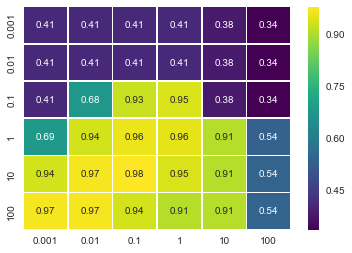

In [153]:
sns.heatmap(scores,xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis", annot=True, linewidths=.5)

gridsearch_failures


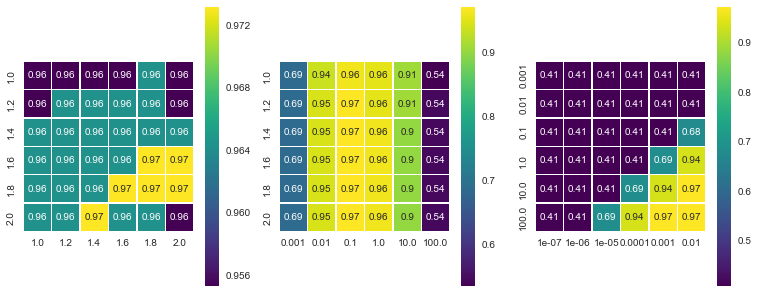

In [154]:
# we see that SVC is very sensitive to parameters 
# the range is actually big enough: the optima are not on the edge of the plot.

fig, axes = plt.subplots(1,3, figsize=(13,5))
param_grid_linear = {'C': np.linspace(1,2,6),'gamma': np.linspace(1,2,6)}
param_grid_one_log = {'C': np.linspace(1,2,6),'gamma': np.logspace(-3,2,6)}
param_grid_range = {'C': np.logspace(-3,2,6),'gamma': np.logspace(-7,-2,6)}

#np.linspace(start,end, number of points in between)
#np.logspace(start,end,num) starts at 10**start and stops at 10**end with num points in between

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    # zip('ABCD', 'xy') --> Ax By
    grid_search = GridSearchCV(SVC(),param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    scores = pd.DataFrame(grid_search.grid_scores_)['mean_validation_score'].reshape(6,6)
    # why reshape ??
    scores_image = sns.heatmap(scores, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], square=True, cmap= "viridis", ax=ax, annot=True, linewidths=.5)
print("gridsearch_failures")

In [155]:
# first panel shows no major changes: either the choices of C, gamma dont matter or we just chose wrong scale
# second panel shows vertical stripe: gamma makes a difference, but C not sure
# third panel: C,gamma both make a difference

## Using different cross-validation strategies with grid-search

we can use `ShuffleSplit`, or `StratifiedShuffleSplit` with `n_iter =1` in case of very large datasets or slow models.

## Nested Cross-validation

is usually not used for parameter selection but rather to see how well a given model generalizes

In [157]:

scores = cross_val_score(GridSearchCV(SVC(),param_grid, cv=5),iris.data,iris.target, cv=15)
print("cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())
print("Std cross-validation score: ", scores.std())

cross-validation scores:  [ 1.          0.91666667  1.          1.          1.          0.77777778
  1.          0.88888889  1.          0.88888889  1.          1.          1.
  1.          1.        ]
Mean cross-validation score:  0.964814814815
Std cross-validation score:  0.064523153297


In [158]:
def nested_cv(X,y,inner_cv,outer_cv, Classifier, parameter_grid):
    outer_scores=[]
    for training_samples, test_samples in outer_cv(X,y):
        # find best parameters using inner cross-validation:
        best_parms = {}
        best_score = -np.inf
        # iterating over parameters
        for parameters in parameter_grid:
            cv_scores = []
            for inner_train, inner_test in inner_cv(X[training_samples],y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X[inner_train],y[inner_train])
                score = clf.score(X[inner_test],y[inner_test])
                cv_scores.append(score)
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_parms = parameters
                best_score = mean_score
        clf = Classifier(**best_parms)
        clf.fit(X[training_samples],y[training_samples])
        outer_scores.append(clf.score(X[test_samples],y[test_samples]))
    return np.array(outer_scores)

            
# couldn't find .split online. Should be obvious what it is though


In [160]:
# issue: nested_cv(iris.data,iris.target,StratifiedKFold(iris.target,5),StratifiedKFold(iris.target,5),SVC,ParameterGrid(param_grid))
# param_grid = {'a': [1, 2], 'b': [True, False]} 
# list(ParameterGrid(param_grid)) ->([{'a': 1, 'b': True}, {'a': 1, 'b': False}, {'a': 2, 'b': True}, {'a': 2, 'b': False}])


# Evaluation metrics and scoring 

## Imbalanced datasets 

Datasets in which one class is much more frequent than the other are called _imbalanced dataset_. The main idea is that in such datasets the accuracy score of machine learning algorithm is not very informative about the actual predictive performance. Let us look at an example to highlight how little informative such an accuracy score can be.

In [162]:
digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data,y, random_state=0)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train,y_train) # just predicts whichever digit is most frequent
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: %s" %np.unique(pred_most_frequent))
print("Test score: %.2f" % dummy_majority.score(X_test,y_test))

Unique predicted labels: [False]
Test score: 0.90


We clearly didn't learn anything, while the so-called accuracy is 90%. Let us compare this with an actual classifier

In [163]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
pred_tree = tree.predict(X_test)
print("Test score: %.2f" %tree.score(X_test,y_test))

Test score: 0.92


It seems like our Decision Tree is only slightly better than the constant predictor, so something is clearly wrong. Let us compare two more classifiers.

In [165]:
dummy = DummyClassifier().fit(X_train,y_train) # just predicts random predictions
pred_dummy = dummy.predict(X_test)
print("dummy score: %.2f" % dummy.score(X_test,y_test))

logreg = LogisticRegression(C=0.1).fit(X_train,y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: %.2f" % logreg.score(X_test,y_test))

dummy score: 0.83
logreg score: 0.98


In order to better judge which predcitors are good, we need different metrics.  

## Confusion Matrices

One such example is _confusion matrices_ 

In [167]:
from sklearn.metrics import confusion_matrix 
confusion = confusion_matrix(y_test,pred_logreg)
print(confusion)

[[401   2]
 [  8  39]]


In [168]:
print("'Most frequent class' predictor:")
print(confusion_matrix(y_test,pred_most_frequent))
print("\n Dummy model:")
print(confusion_matrix(y_test,pred_dummy))
print("\n Decision Tree:")
print(confusion_matrix(y_test,pred_tree))
print("\n Logistic Regression:")
print(confusion_matrix(y_test,pred_logreg))

'Most frequent class' predictor:
[[403   0]
 [ 47   0]]

 Dummy model:
[[356  47]
 [ 42   5]]

 Decision Tree:
[[390  13]
 [ 24  23]]

 Logistic Regression:
[[401   2]
 [  8  39]]


it is kinda like this:`[[TN, FP],[FN, TP]]` 

Accuracy = $\displaystyle \frac{TP+TN}{TP+TN+FP+FN}$

Precision = $\displaystyle \frac{TP}{TP+FP}$. "how many of those predicted positive are actually positive". used when goal is to limit FP. **Example**: drug for curing disease

Recall = $\displaystyle\frac{TP}{TP+FN}$. (also called _Sensitivity_) used when goal is to avoid FN. **Example:** find all people with certain disease.

There is a trade-off between optimizing Recall and Precision. It's very easy to perform good one but not the other. Thus the introdcution of the _f-score_: $$\displaystyle F = 2\cdot\frac{\textrm{precision}\cdot \textrm{recall}}{\textrm{precision}+ \textrm{recall}} $$ which is the harmonic mean of precision and recall. 

There is a variant called _f1-score_.

In [173]:
print("f1 score  most frequent: %.2f " %f1_score(y_test,pred_most_frequent))
print("f1 score dummy: %.2f" %f1_score(y_test,pred_dummy))
print("f1 score tree: %.2f" %f1_score(y_test,pred_tree))
print("f1 score logistic regression: %.2f" %f1_score(y_test,pred_logreg))

f1 score  most frequent: 0.00 
f1 score dummy: 0.10
f1 score tree: 0.55
f1 score logistic regression: 0.89


/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


It shows much more leverage in between the classifiers, but on the flipside is harder to interpret and explain. 

In [174]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.90      1.00      0.94       403
       nine       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [175]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.89      0.88      0.89       403
       nine       0.10      0.11      0.10        47

avg / total       0.81      0.80      0.81       450



In [176]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.98      1.00      0.99       403
       nine       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450



Picking which class is declared the positive class has a big impact on the metrics

## Taking uncertainty into account

In [180]:
X, y = make_blobs(n_samples=400, centers=2, cluster_std=[7.0,2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
svc=SVC(gamma=.05).fit(X_train,y_train)
print(classification_report(y_test,svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.98      0.88      0.92        56
          1       0.86      0.98      0.91        44

avg / total       0.93      0.92      0.92       100



In [182]:
y_pred_lower_treshold = svc.decision_function(X_test) > -.8
# lowers the treshold, so more points are being classified as 1. producing higher recall for class 1. 

In [183]:
print(classification_report(y_test,y_pred_lower_treshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90        56
          1       0.81      1.00      0.90        44

avg / total       0.92      0.90      0.90       100



another tool to play with this is the method `.predict_proba()`. Say you set this treshold to 0.68 then the model has to be 68% "sure" that the point is of positive class, to be classified as such.

## Precision-Recall curves and ROC curves

`from sklearn.metrics import precision_recall_curve
precision, recall, tresholds = precision_recall_curve(y_test, svc.decision_function(X_test))`

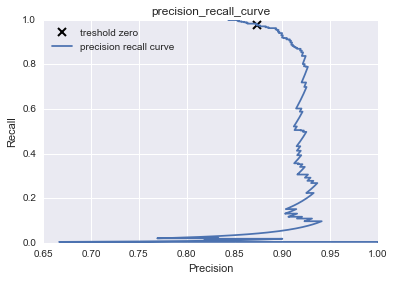

In [196]:
from sklearn.metrics import precision_recall_curve
X,y = make_blobs(n_samples=4000, centers=2, cluster_std=[7.0,2], random_state =22)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
svc= SVC(gamma=.05).fit(X_train,y_train)
precision, recall, tresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
close_zero = np.argmin(np.abs(tresholds)) #finds treshold closest to zero 
plt.plot(precision[close_zero], recall[close_zero],'x',markersize=8, label = "treshold zero", fillstyle="none", c="k", mew =2)
plt.plot(precision,recall, label = "precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("precision_recall_curve")
plt.legend(loc="best")

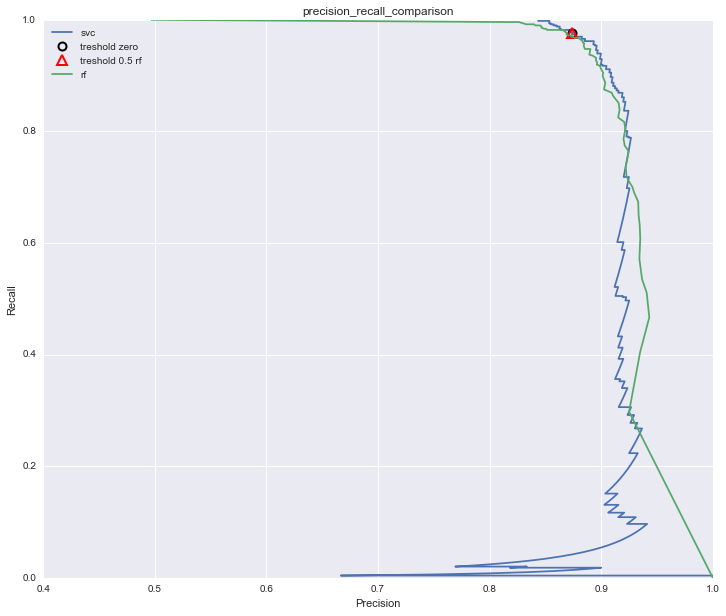

In [217]:
rf= RandomForestClassifier(n_estimators=100, random_state=0, max_features=2).fit(X_train,y_train)
precision_rf, recall_rf, tresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,10))
plt.plot(precision,recall, label = "svc")
plt.plot(precision[close_zero], recall[close_zero],'o',markersize=8, label = "treshold zero", fillstyle="none", c="k", mew =2)


close_default_rf = np.argmin(np.abs(tresholds_rf - 0.5)) #finds treshold closest to zero 
plt.plot(precision[close_default_rf], recall[close_default_rf],'^',markersize=10, label = "treshold 0.5 rf", fillstyle="none", c="r", mew =2)
plt.plot(precision_rf,recall_rf, label = "rf")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("precision_recall_comparison")
plt.legend(loc="best")

We can see that random forest performs better at the extremes, for very high recall or very high precision requirements 

In [213]:
print("F1 score for SVC: %.2f" %f1_score(y_test, svc.predict(X_test)))
print("F1 score for random forest: %.2f" %f1_score(y_test, rf.predict(X_test)))

F1 score for SVC: 0.92
F1 score for random forest: 0.92


In [218]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("average precision of random forest: %.3f" % ap_rf)
print("average precision of svc: %.3f" %ap_svc)
# which predictors have the `.predict_proba()` and which the `.decision_function()`method and why?

average precision of random forest: 0.933
average precision of svc: 0.914


## Receiver Operating Characteristics (ROC) and AUC

Instead of drawing recall against precision, we can also draw **TPR** (true positive rate) against **FPR** (false positive rate), this curve is calles the **_receiver operating curve_**.

$ \displaystyle FPR = \frac{FP}{FP+TN}$ and $TPR = \textrm{recall} = \displaystyle\frac{TP}{TP+FN}$

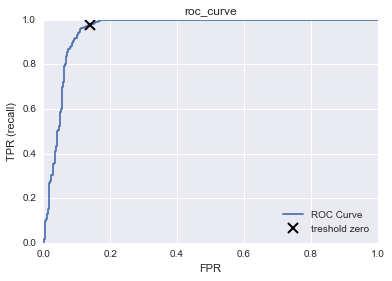

In [226]:
from sklearn.metrics import roc_curve
fpr, tpr, tresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr,tpr, label = "ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve")
close_zero = np.argmin(np.abs(tresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'x',markersize=10, label="treshold zero", fillstyle ="none", c='k', mew=2)
plt.legend(loc=4)

As with the precision-recall curve, we often want to summarize the ROC curve with a single number, the area under the curve _AUC_. AUC is for ROC, what the _f-score_ or _f1-score_ is for the precision-recall curve. 

In [231]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]) # why [:,1] ?
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: %.3f" %rf_auc)
print("AUC for SVC: %.3f" %svc_auc)

AUC for Random Forest: 0.954
AUC for SVC: 0.953


Note that predicting randomly produces AUC of 0.5 no matter how imbalanced the dataset is. This makes AUC a much better metric for imbalanced classification problems than accuracy. 

The AUC can be interpreted as **_evaluating the ranking of positive samples_**

AUC = probability that a randomly picked point of positive class will have higher score (according to the classifier) than a randomly picked point from the negative class. 

Let us now go back to problem with the digits dataset

gamma = 1.00 accuracy 0.90 AUC = 0.50
gamma = 0.05 accuracy 0.90 AUC = 0.90
gamma = 0.01 accuracy 0.90 AUC = 1.00


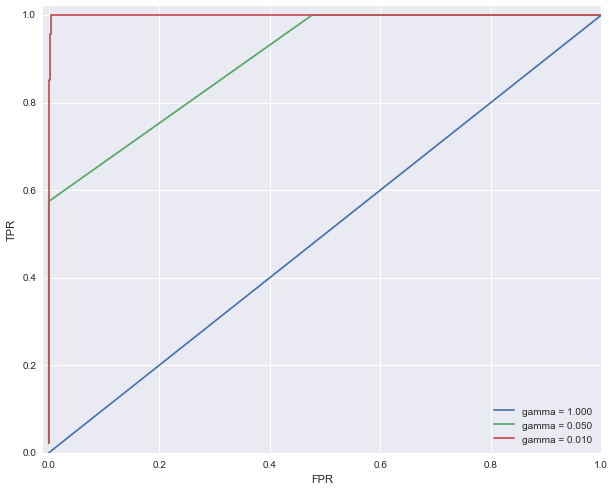

In [238]:
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 0)
plt.figure(figsize=(10,8))
for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma = gamma).fit(X_train,y_train)
    accuracy = svc.score(X_test,y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr,tpr,_ = roc_curve(y_test, svc.decision_function(X_test)) #Q: what is this '_'for?
    print("gamma = %.02f accuracy %.02f AUC = %.02f" %(gamma,accuracy,auc))
    plt.plot(fpr,tpr,label="gamma = %.03f" % gamma)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01,1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

the smaller `gamma` is the better the performance. All positive points are ranked higher than all negative points according to the decision function. With the right treshold, this model can classify the data perfectly (almost cf. top left corner).

## Multi-class classification

All metrics for multi-class classification are derived from binary classification metrics, but averaged over all classes.

In [240]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state= 0)
lr = LogisticRegression().fit(X_train,y_train)
pred = lr.predict(X_test)
print("accuracy: %.03f" % accuracy_score(y_test,pred))
print("confusion matrix:")
print(confusion_matrix(y_test,pred))

accuracy: 0.953
confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


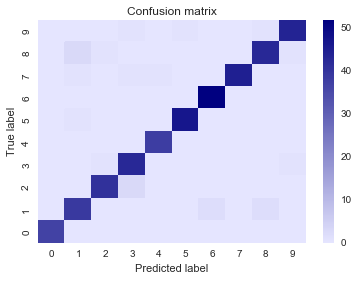

In [256]:
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(y_test,pred), xticklabels = digits.target_names, yticklabels = digits.target_names ,cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [258]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



F-scores can be computed by averaging in various way:
* `"macro"`: computes the unweighted average of the per-class f-scores. gives equal weight to all classes.
* `"weighted"`: computes the mean of the per-class f-scores, weighted by their support.
* `"micro"`: computes total number of false positives, flase negatives and true positives over all classes, and then computes precision, recall and f-score using these counts.

In [259]:
print("micro average f1 score: %.3f" % f1_score(y_test, pred, average = "micro"))
print("macro average f1 score: %.3f" % f1_score(y_test, pred, average = "macro"))

micro average f1 score: 0.953
macro average f1 score: 0.954


## Regression metrics

Generally $R^2$ is doing a pretty good job for evaluating regression models. In some cases one might be interested in using mean squared error or mean aboslute error.

## Using evaluation metrics in model selection 

In [260]:
print("default scoring" , cross_val_score(SVC(), digits.data, digits.target == 9))

explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9 ,scoring = "accuracy")
print("explicit accuracy scoring", explicit_accuracy)

roc_auc = cross_val_score(SVC(), digits.data, digits.target ==9, scoring = "roc_auc")
print("AUC scoring", roc_auc)

default scoring [ 0.89983306  0.89983306  0.89983306]
explicit accuracy scoring [ 0.89983306  0.89983306  0.89983306]
AUC scoring [ 0.99370748  0.98957947  0.99594929]


In [269]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state = 0)
param_grid = {'gamma':[0.0001,0.01,0.1,1,10]}


#using default scoring of accuracy
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_ )
print("Best cross-validation score (accuracy): %.3f" %grid.best_score_)
print("Test set AUC: %.3f" %roc_auc_score(y_test,grid.decision_function(X_test)))
print("Test set accuracy: %.3f" % grid.score(X_test,y_test))

#using AUC scoring instead 
grid = GridSearchCV(SVC(), param_grid = param_grid, scoring = "roc_auc")
grid.fit(X_train, y_train)
print("\nGrid Search with AUC")
print("Best parameters:" ,grid.best_params_)
print("Best cross_validation score (AUC): %.3f" %grid.best_score_)
print("Test set AUC: %.3f" %roc_auc_score(y_test,grid.decision_function(X_test)))
print("Test set accuracy: %.3f" % grid.score(X_test,y_test))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973

Grid Search with AUC
Best parameters: {'gamma': 0.01}
Best cross_validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
